In [1]:
import yfinance as yf, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

In [2]:
df = yf.download('BTC-USD',start="2021-01-01", end=None)

[*********************100%%**********************]  1 of 1 completed


In [3]:
columns = ['Adj Close']
df_copy = df[columns].copy()
df_copy.index = df_copy.index.to_period("D")

In [4]:
# days and week
df_copy["dayofweek"] = df_copy.index.dayofweek
df_copy["week"] = df_copy.index.week
# days and year
df_copy["dayofyear"] = df_copy.index.dayofyear
df_copy["year"] = df_copy.index.year

In [5]:
# annotations: https://stackoverflow.com/a/49238256/5769929 seasonal plots

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        # ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

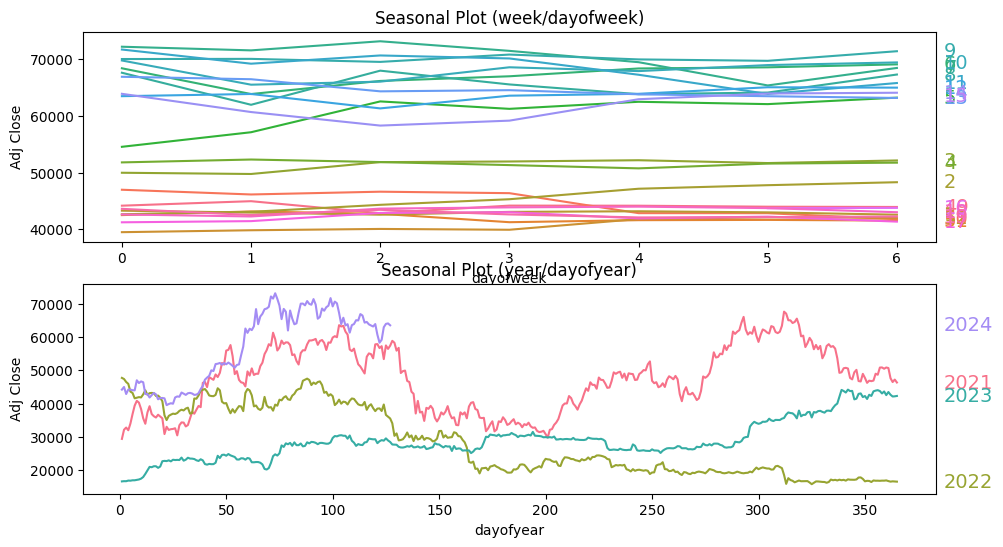

In [14]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(df_copy.tail(150), y="Adj Close", period="week", freq="dayofweek", ax=ax0)
seasonal_plot(df_copy, y="Adj Close", period="year", freq="dayofyear", ax=ax1);

In [7]:
# Periodogram
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

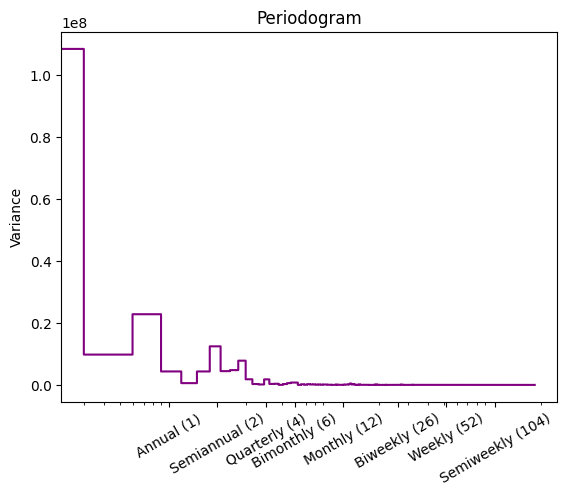

In [8]:
plot_periodogram(df_copy['Adj Close']);

In [23]:
# Periodogram show no week seasonality and some anual seasonality we can create one sin/cos pair to represent this
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="YE", order=1)  

dp = DeterministicProcess(
    index = df_copy.index,
    constant=True,
    order=1,
    seasonal=False,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()
X.head()

,const,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)"
Date,,,,
2021-01-01,1.0,1.0,0.000000,1.000000
2021-01-02,1.0,2.0,0.017213,0.999852
2021-01-03,1.0,3.0,0.034422,0.999407
2021-01-04,1.0,4.0,0.051620,0.998667
2021-01-05,1.0,5.0,0.068802,0.997630


In [24]:
# Use fourier features to forcast seasonality
from sklearn.linear_model import LinearRegression

y = df_copy['Adj Close']

model = LinearRegression(fit_intercept=False)
_ = model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=100)
y_fore = pd.Series(model.predict(X_fore),index=X_fore.index)

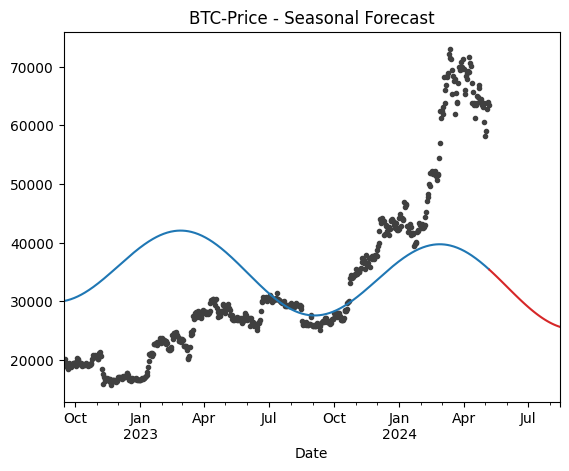

In [25]:
ax = y.tail(600).plot(color='0.25', style='.', title="BTC-Price - Seasonal Forecast")
ax = y_pred.tail(600).plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')

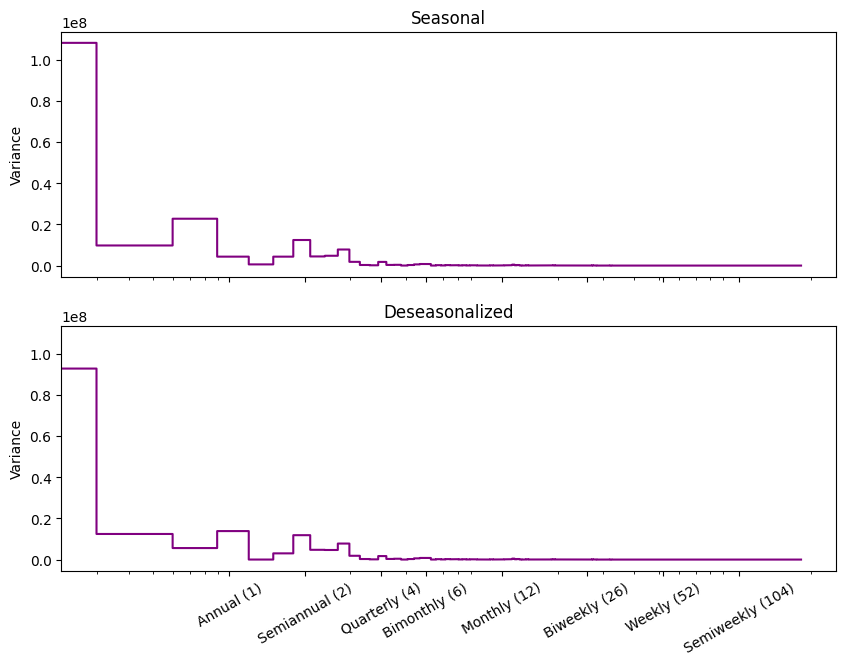

In [26]:
# plot deseasonalisation
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Seasonal")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [27]:
It seems that the model was unable to learn some seasonality

SyntaxError: invalid syntax (3453725552.py, line 1)